# Лабораторная работа №4


### 1. Предварительная обработка данных

In [1]:
from google.colab import files
uploaded = files.upload()

Saving telecom_churn.csv to telecom_churn.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score, homogeneity_score, completeness_score, v_measure_score, confusion_matrix

df = pd.read_csv('telecom_churn.csv')
print("Исходный размер:", df.shape)
df.head()

Исходный размер: (3016, 12)


,age,gender,contract_type,payment_method,tenure_months,monthly_charges,total_charges,avg_call_minutes,num_support_tickets,has_international_plan,region,Churn
0,53,M,Month-to-month,Bank transfer,58,56.46,3448.16,206.9,0,No,North,0
1,18,F,Month-to-month,Electronic check,16,64.86,1227.48,345.3,2,Yes,West,1
2,81,M,Month-to-month,Electronic check,59,97.64,5773.27,242.8,0,No,North,0
3,65,F,One year,Credit card,16,27.90,416.11,257.2,0,Yes,North,0
4,40,F,Month-to-month,Electronic check,65,56.33,3805.53,205.1,1,No,North,0


In [3]:
# 2. Предварительная обработка данных
# Оценим пропуски и типы
print(df.info())
print(df.isna().sum())

# Обработка пропусков:
# - для числовых столбцов заполним медианой,
# - для категориальных — заполнить наиболее частым значением.
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Числовые:", num_cols)
print("Категориальные:", cat_cols)

# Заполнение пропусков
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())

for c in cat_cols:
    df[c] = df[c].fillna(df[c].mode().iloc[0])

# Приведём бинарные текстовые поля к Yes/No единообразно и закодируем

# Приведём Churn к 0/1
df['Churn'] = df['Churn'].map({1:1, '1':1, 'Yes':1, 'Y':1, 'yes':1, 'TRUE':1, 'True':1, 0:0, '0':0, 'No':0, 'N':0, 'no':0, 'False':0})


df['Churn'] = df['Churn'].fillna(0).astype(int)

# Переоценим типы
print(df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3016 entries, 0 to 3015
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     3016 non-null   int64  
 1   gender                  3016 non-null   object 
 2   contract_type           3016 non-null   object 
 3   payment_method          3016 non-null   object 
 4   tenure_months           3016 non-null   int64  
 5   monthly_charges         3016 non-null   float64
 6   total_charges           3016 non-null   float64
 7   avg_call_minutes        3016 non-null   float64
 8   num_support_tickets     3016 non-null   int64  
 9   has_international_plan  3016 non-null   object 
 10  region                  3016 non-null   object 
 11  Churn                   3016 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 282.9+ KB
None
age                       0
gender                    0
contract_type             

### 2. Определение целевой переменной

В рамках анализа данных из файла telecom_churn.csv, основной задачей является прогнозирование оттока клиентов, то есть определение вероятности того, что клиент прекратит использование услуг телекоммуникационной компании.

Поэтому целевая переменная была выбрана **"Churn"**.

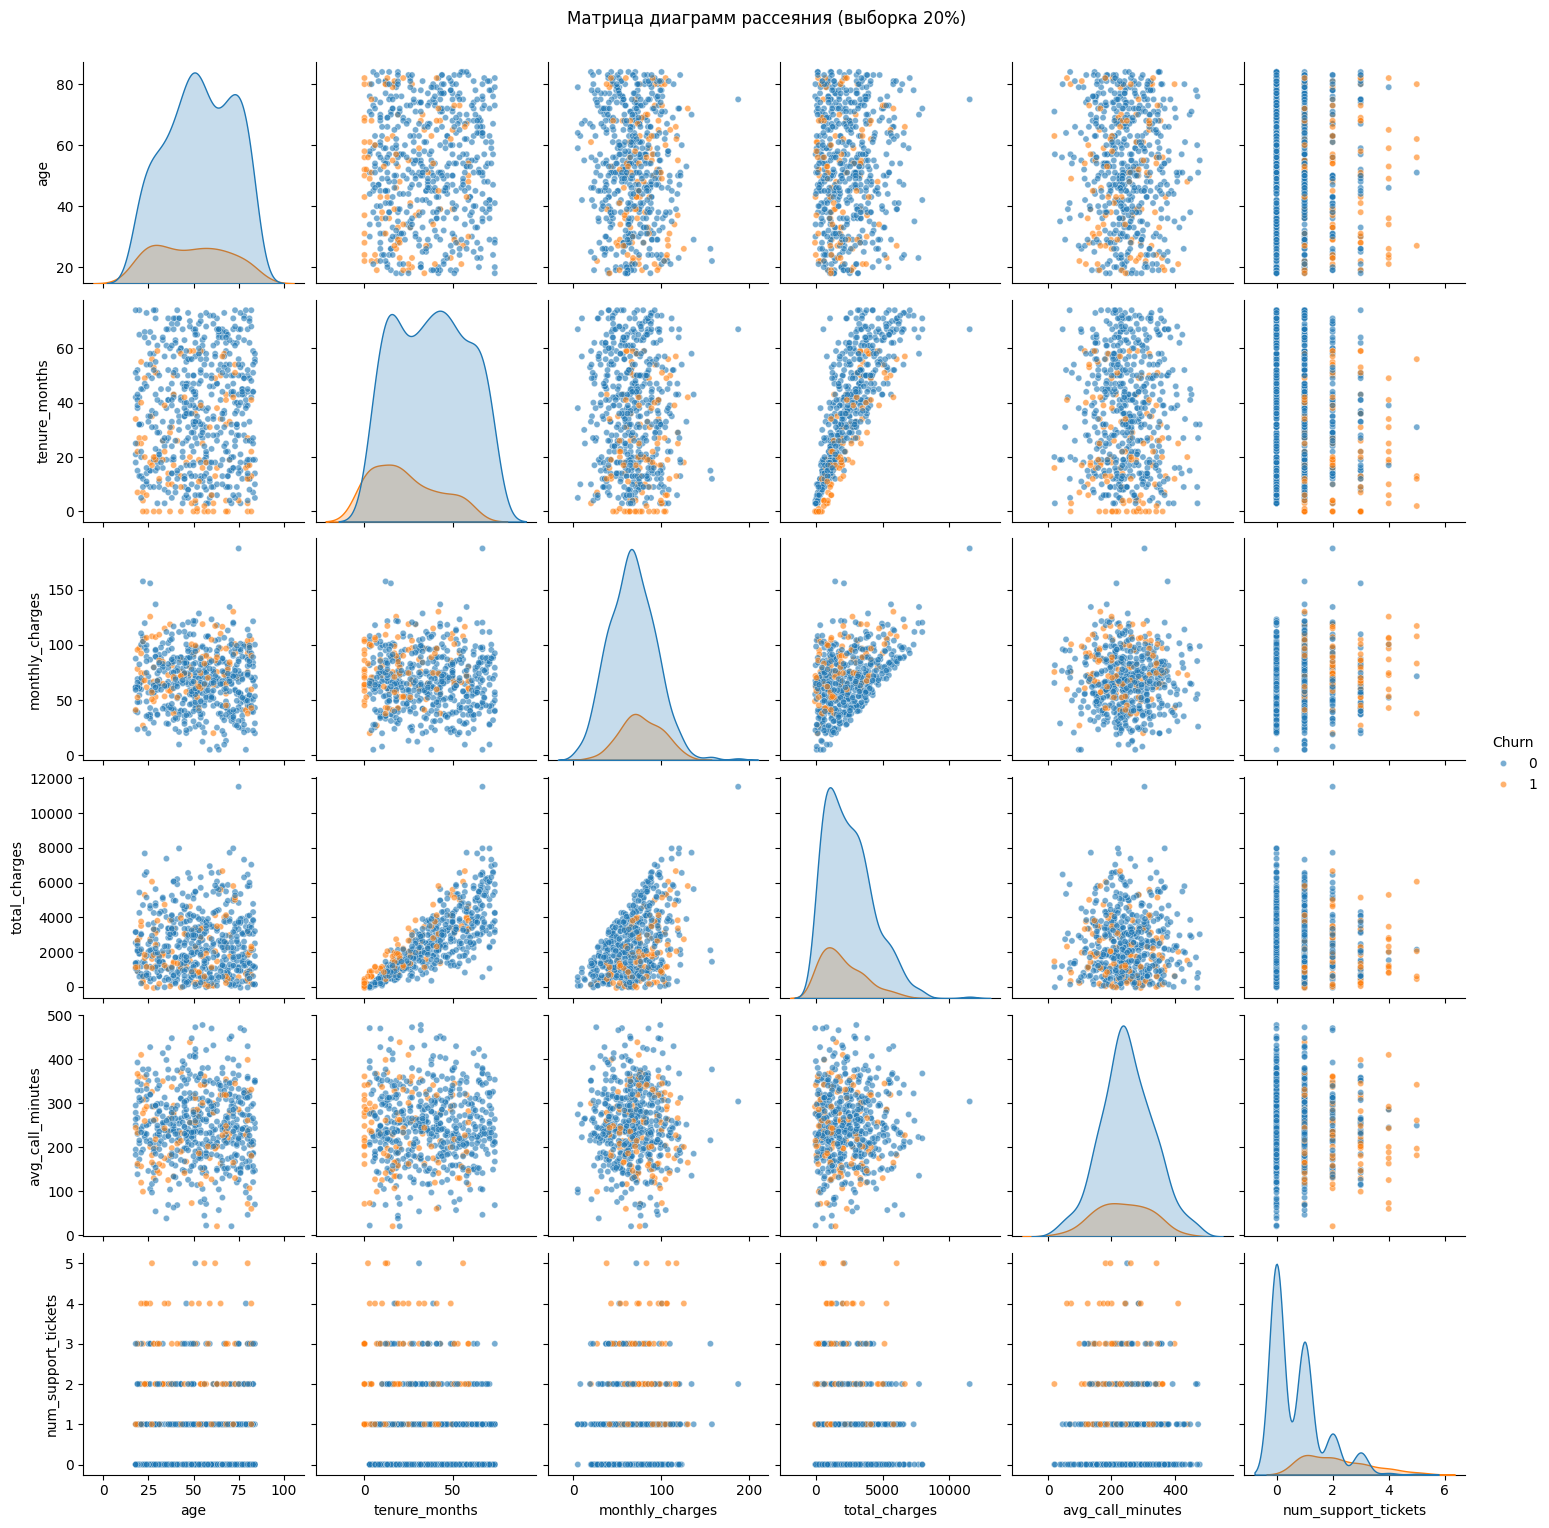

In [4]:
# 3. Выделение целевой переменной и scatter matrix
target = 'Churn'
features = [c for c in df.columns if c != target]

# Для матрицы рассеяния оставим только числовые признаки (чтобы график был читаемым)
num_feats = df.select_dtypes(include=[np.number]).columns.tolist()
num_feats = [c for c in num_feats if c != target]

# Построим pairplot, раскрасив по Churn
sns.pairplot(df.sample(frac=0.2, random_state=42)[num_feats + [target]], hue=target, diag_kind='kde', plot_kws={'s':20, 'alpha':0.6})
plt.suptitle('Матрица диаграмм рассеяния (выборка 20%)', y=1.02)
plt.show()

### Выводы по матрицам рассеяния

*  tenure_months (Стаж обслуживания). Этот признак является самым сильным индикатором оттока. Ушедшие клиенты (оранжевые точки) сосредоточены в левой части графика, то есть у них очень маленький стаж (часто 0-20 месяцев). Клиенты, которые остались (синие точки), в основном имеют большой стаж (50+ месяцев). Чем меньше стаж, тем выше вероятность оттока.

*  total_charges (Общая сумма платежей). Связан с tenure_months. Ушедшие клиенты чаще всего имеют низкую общую сумму платежей, что логично, так как они были клиентами недолго. Клиенты с высокой общей суммой почти всегда остаются.

*  monthly_charges (Ежемесячные платежи). Здесь наблюдается обратная тенденция. Ушедшие клиенты (оранжевые) чаще всего платят больше в месяц, чем те, кто остается (синие). Это может указывать на то, что высокая стоимость услуг является важным фактором оттока.

### 3. Стандартизация числовых данных и разделение на тестовый и тренировочный датасеты

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

In [6]:
# Целевая переменная
target = 'Churn'
y = df[target]

# Признаки: все столбцы, кроме целевой переменной
X = df.drop(columns=[target])

In [7]:
# Разделим данные: 75% — обучение, 25% — тест
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y  # сохраняем пропорции классов в обеих выборках
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (2262, 11)
Размер тестовой выборки: (754, 11)


In [8]:
# Определим числовые и категориальные столбцы
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

print("Числовые признаки:", num_cols)
print("Категориальные признаки:", cat_cols)

Числовые признаки: ['age', 'tenure_months', 'monthly_charges', 'total_charges', 'avg_call_minutes', 'num_support_tickets']
Категориальные признаки: ['gender', 'contract_type', 'payment_method', 'has_international_plan', 'region']


In [10]:
# Создаём копии, чтобы не повредить оригинальные данные
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Инициализируем стандартизатор
scaler = StandardScaler()

# Обучаем на обучающей выборке и применяем к обеим выборкам
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

In [11]:
# Проверим среднее и стандартное отклонение после стандартизации
print("Среднее по числовым признакам в X_train_scaled:")
print(X_train_scaled[num_cols].mean().round(6))
print("\nСтандартное отклонение:")
print(X_train_scaled[num_cols].std().round(6))

Среднее по числовым признакам в X_train_scaled:
age                    0.0
tenure_months          0.0
monthly_charges        0.0
total_charges          0.0
avg_call_minutes       0.0
num_support_tickets    0.0
dtype: float64

Стандартное отклонение:
age                    1.000221
tenure_months          1.000221
monthly_charges        1.000221
total_charges          1.000221
avg_call_minutes       1.000221
num_support_tickets    1.000221
dtype: float64


### 4. Разработка предсказательной модели качественного отклика методом k-ближайших соседей (k-Nearest Neighbors, kNN)

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

Важно перед обучением закодировать категориальные признаки, так как KNN работает только с числовыми данными. Воспользуемся One-Hot Encoding через pd.get_dummies.

In [13]:
# Объединим X_train_scaled (численные) и категориальные признаки
X_train_knn = pd.concat([
    X_train_scaled[num_cols],
    pd.get_dummies(X_train[cat_cols], drop_first=True)
], axis=1)

X_test_knn = pd.concat([
    X_test_scaled[num_cols],
    pd.get_dummies(X_test[cat_cols], drop_first=True)
], axis=1)

# Выравниваем колонки (вдруг в тесте нет какого-то уровня)
X_test_knn = X_test_knn.reindex(columns=X_train_knn.columns, fill_value=0)

Теперь обучим базовую модель kNN с параметром по умолчанию (k=5).

In [15]:
# Создание и обучение модели kNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_knn, y_train)

# Предсказания
y_pred_knn = knn_model.predict(X_test_knn)
y_proba_knn = knn_model.predict_proba(X_test_knn)[:, 1]

In [16]:
# Вычисление метрик
acc_knn = accuracy_score(y_test, y_pred_knn)
prec_knn = precision_score(y_test, y_pred_knn)
rec_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)
roc_auc_knn = roc_auc_score(y_test, y_proba_knn)

print("Метрики качества модели kNN:")
print(f"Accuracy:    {acc_knn:.4f}")
print(f"Precision:   {prec_knn:.4f}")
print(f"Recall:      {rec_knn:.4f}")
print(f"F1-score:    {f1_knn:.4f}")
print(f"ROC-AUC:     {roc_auc_knn:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn))

Метрики качества модели kNN:
Accuracy:    0.8674
Precision:   0.6136
Recall:      0.4500
F1-score:    0.5192
ROC-AUC:     0.8240

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       634
           1       0.61      0.45      0.52       120

    accuracy                           0.87       754
   macro avg       0.76      0.70      0.72       754
weighted avg       0.86      0.87      0.86       754



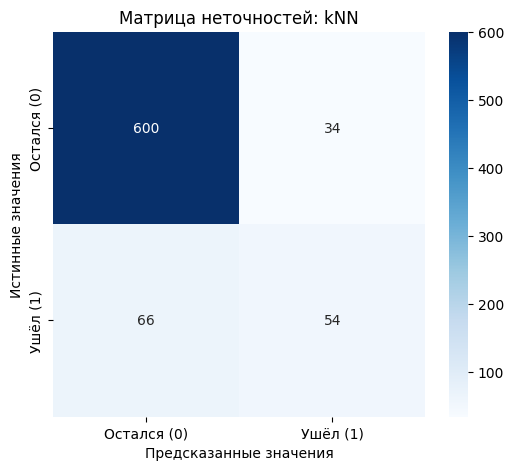

In [17]:
plt.figure(figsize=(6, 5))
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Остался (0)', 'Ушёл (1)'],
            yticklabels=['Остался (0)', 'Ушёл (1)'])
plt.title('Матрица неточностей: kNN')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.show()

### Выводы по метрикам качества и матрице неточностей



*   **Accuracy = 0.8674** означает, что модель правильно классифицировала 86.74% всех клиентов. Однако, как видно из Classification Report, датасет несбалансирован: 634 клиента остались (0), а только 120 ушли (1). Модель может просто "угадывать" большинство класса (0) и при этом показывать высокую общую точность.
*   Модель имеет сильный перекос в сторону класса "Остался" (0). Это наглядно видно из матрицы неточностей.

    Истинно отрицательные **(TN)** имеет значение 600, то есть модель правильно предсказала, что 600 клиентов останутся.

    Ложно положительные **(FP)** имеет значение 34, то есть модель ошибочно предсказала уход 34-м клиентам, которые на самом деле остались.

    Ложно отрицательные **(FN)** имеет значение 66, то есть модель ошибочно предсказала, что 66 клиентов останутся, хотя они фактически ушли. Это критическая ошибка для задачи оттока.

    Истинно положительные **(TP)** имеет значение 54, то есть модель правильно предсказала уход только 54-х клиентов из 120.

    Таким образом, из 120 реальных ушедших клиентов модель смогла выявить лишь 54 (45%). Это очень низкий показатель для бизнес-задачи, где важно именно выявить тех, кто собирается уйти.

*  Низкая полнота (Recall) для класса "Ушёл" (1), что можно считать главной проблемой.

    **Recall (для класса 1) = 0.4500.** Эта метрика показывает, какую долю реально ушедших клиентов модель смогла обнаружить. Значение 45% означает, что модель пропускает 55% потенциальных уходящих клиентов.
    
    В контексте задачи оттока это означает, что маркетинговые кампании по удержанию, основанные на этой модели, будут эффективны только для половины клиентов, которые действительно собираются уйти. Остальные 55% уйдут, так как их не было в списке "рискованных".

*  Точность (Precision) для класса "Ушёл" (1) также невысока.

    **Precision (для класса 1) = 0.6136.** Эта метрика показывает, насколько надежно модель определяет уход: из всех клиентов, которых она пометила как "ушедшие", 61.36% действительно ушли.
    
    Это означает, что примерно 39% клиентов, получивших "предупреждение" от модели, на самом деле останутся. Это может привести к напрасным затратам на удержание лояльных клиентов.

*   F1-мера тоже низкая для класса "Ушёл".

    **F1-score (для класса 1) = 0.5192.** Поскольку F1-мера является гармоническим средним Precision и Recall, ее низкое значение подтверждает, что модель плохо справляется с классом "Ушёл" (1).

*  ROC-AUC показывает хорошее качество ранжирования, но не решает проблему дисбаланса.

    **ROC-AUC = 0.824**0 — это хороший показатель. Он говорит о том, что модель хорошо различает объекты двух классов, то есть вероятности, которые она выдает, хорошо ранжируют клиентов по степени риска ухода.
    
    Однако ROC-AUC не чувствителен к дисбалансу классов. Модель может отлично ранжировать, но при применении порога для принятия решения (например, "если вероятность > 0.5, то клиент уйдет") все равно будет давать много ложных срабатываний или пропусков, особенно если порог не настроен специально для несбалансированного датасета.

Таким образом, модель kNN демонстрирует высокую общую точность, но очень низкую способность выявлять клиентов, которые действительно уйдут (низкий Recall). Для задачи прогнозирования оттока клиентов это неприемлемо, так как основная цель именно вовремя обнаружить "рискованных" клиентов для проведения мер по их удержанию. Модель в текущем виде будет пропускать более половины уходящих клиентов.

### 5. Разработка предсказательной модели качественного отклика методом дерева решений

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
# One-Hot Encoding для категориальных признаков
X_train_dt = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test_dt = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

# Выравнивание колонок (на случай, если в тестовой выборке нет некоторых значений)
X_test_dt = X_test_dt.reindex(columns=X_train_dt.columns, fill_value=0)

In [21]:
# Создание модели (без ограничений на глубину, скорее всего будет переобучение, но это допустимо на начальном этапе)
dt_model = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced'  # Учёт несбалансированности классов
)

# Обучение
dt_model.fit(X_train_dt, y_train)

# Предсказания
y_pred_dt = dt_model.predict(X_test_dt)
y_proba_dt = dt_model.predict_proba(X_test_dt)[:, 1]

In [22]:
# Расчёт метрик
acc_dt = accuracy_score(y_test, y_pred_dt)
prec_dt = precision_score(y_test, y_pred_dt)
rec_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
roc_auc_dt = roc_auc_score(y_test, y_proba_dt)

print("Метрики качества модели дерева решений:")
print(f"Accuracy:    {acc_dt:.4f}")
print(f"Precision:   {prec_dt:.4f}")
print(f"Recall:      {rec_dt:.4f}")
print(f"F1-score:    {f1_dt:.4f}")
print(f"ROC-AUC:     {roc_auc_dt:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

Метрики качества модели дерева решений:
Accuracy:    0.8886
Precision:   0.6552
Recall:      0.6333
F1-score:    0.6441
ROC-AUC:     0.7851

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       634
           1       0.66      0.63      0.64       120

    accuracy                           0.89       754
   macro avg       0.79      0.79      0.79       754
weighted avg       0.89      0.89      0.89       754



### Выводы по метрикам качества

*  Общая точность (**Accuracy = 0.8886 / 88.86%**). Модель в целом работает хорошо, так как почти 89% всех предсказаний верны. Однако этот показатель может быть обманчивым, если классы несбалансированы. В нашем случае, судя по support (количество объектов) в отчете, класс "Остался" (0) значительно больше (634) чем класс "Ушёл" (1) (120). Поэтому Accuracy не дает полной картины, особенно по отношению к редкому классу — оттоку.

*  Точность (**Precision = 0.6552 / 65.52%**). Эта метрика говорит о том, что из всех клиентов, которых модель пометила как "уходящих", только 65.5% действительно ушли. Остальные 34.5% были ложными срабатываниями (FP). Для бизнеса это означает, что если компания начнет активно работать с клиентами, помеченными моделью как "рискованные", то почти треть из них будут "ложными тревогами", что может привести к неэффективному использованию ресурсов маркетинга или службы поддержки.

*  Полнота (**Recall = 0.6333 / 63.33%**). Эта метрика показывает, что модель смогла выявить только 63.3% всех реальных ушедших клиентов (TP из всех реальных 1-ок). Это означает, что 36.7% ушедших клиентов (44 человека) модель не заметила и не предупредила компанию. Для задачи удержания клиентов это критично, так как компания теряет значительную часть потенциальных убытков, не успевая предпринять удерживающие меры.

* F1-мера (**F1-score = 0.6441 / 64.41%**). Это гармоническое среднее Precision и Recall. Значение 64.4% указывает на то, что модель находится в "середине" между двумя противоречивыми метриками. Она не очень хороша ни в точности, ни в полноте, но пытается найти баланс. Это типичный результат для моделей, работающих с несбалансированными данными, где трудно одновременно хорошо предсказывать оба класса.

*  ROC-AUC (**ROC-AUC = 0.7851 / 78.51%**). Площадь под ROC-кривой показывает общую способность модели различать классы независимо от выбранного порога. Значение 0.785 свидетельствует о умеренной способности модели. Это выше случайного угадывания (0.5), но ниже отличных показателей (ближе к 1.0). Модель имеет некоторую дискриминационную силу, но ее можно улучшить.

*  Анализ по классам (**Classification Report**).
    Для класса "Остался" (0) модель работает отлично, так как Precision (93%), Recall (94%) и F1 (93%) очень высокие. Это логично, так как большинство клиентов остаются, и модель легко "угадывает" этот класс.
    
    Для класса "Ушёл" (1) модель работает гораздо хуже, так как Precision (66%), Recall (63%) и F1 (64%). Это подтверждает выводы выше, что модель плохо справляется с предсказанием редкого класса — оттока.

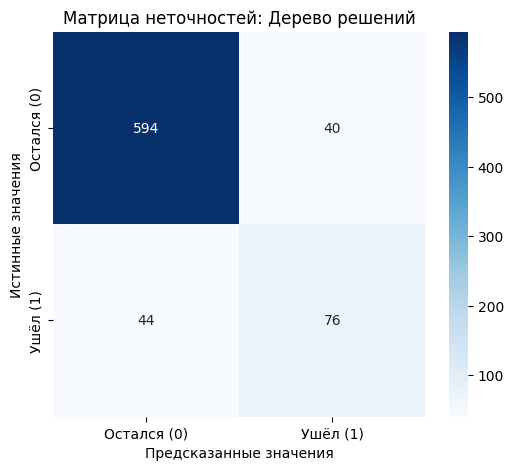

In [23]:
plt.figure(figsize=(6, 5))
cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Остался (0)', 'Ушёл (1)'],
            yticklabels=['Остался (0)', 'Ушёл (1)'])
plt.title('Матрица неточностей: Дерево решений')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.show()

### Выводы по матрице неточностей

*  **Истинно отрицательные (TN - True Negative)**: 594 клиента. Модель правильно предсказала, что эти клиенты останутся (0), и они действительно остались.
*  **Ложноположительные (FP - False Positive)**: 40 клиентов. Модель ошибочно предсказала, что эти клиенты уходят (1), но на самом деле они остались (0).
*  **Ложноотрицательные (FN - False Negative)**: 44 клиента. Модель ошибочно предсказала, что эти клиенты останутся (0), но на самом деле они ушли (1). Это наиболее критичная ошибка для бизнеса, так как компания не успела принять меры по удержанию этих клиентов.
*  **Истинно положительные (TP - True Positive)**: 76 клиентов. Модель правильно предсказала, что эти клиенты уходят (1), и они действительно ушли.

### 6. График ROC-кривой


In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [25]:
# Вероятности для kNN и дерева решений
y_proba_knn = knn_model.predict_proba(X_test_knn)[:, 1]
y_proba_dt = dt_model.predict_proba(X_test_dt)[:, 1]

# Вычисление ROC-кривых
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba_knn)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)

# Вычисление AUC
auc_knn = auc(fpr_knn, tpr_knn)
auc_dt = auc(fpr_dt, tpr_dt)

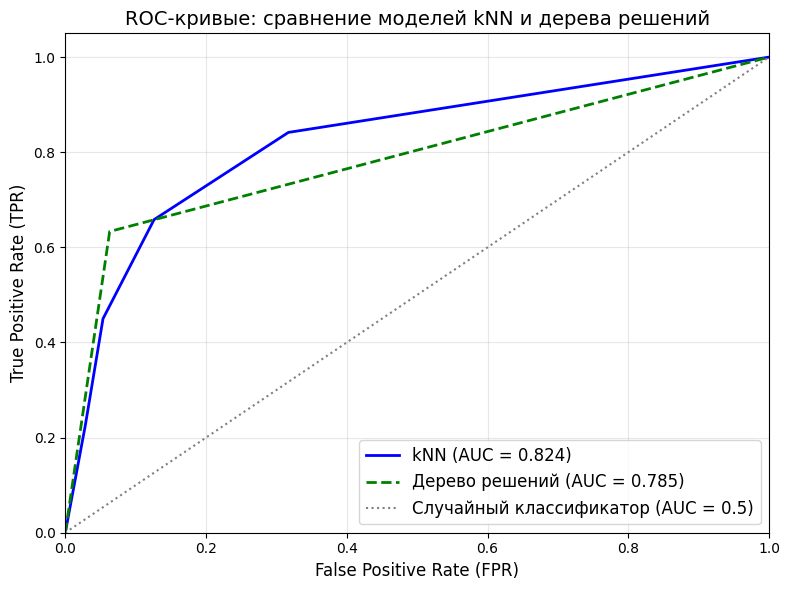

In [26]:
plt.figure(figsize=(8, 6))

# ROC-кривая для kNN
plt.plot(fpr_knn, tpr_knn,
         label=f'kNN (AUC = {auc_knn:.3f})',
         color='blue', linestyle='-', linewidth=2)

# ROC-кривая для дерева решений
plt.plot(fpr_dt, tpr_dt,
         label=f'Дерево решений (AUC = {auc_dt:.3f})',
         color='green', linestyle='--', linewidth=2)

# Диагональ (случайный классификатор)
plt.plot([0, 1], [0, 1],
         color='gray', linestyle=':', linewidth=1.5,
         label='Случайный классификатор (AUC = 0.5)')

# Оформление
plt.title('ROC-кривые: сравнение моделей kNN и дерева решений', fontsize=14)
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

### Выводы по ROC-кривой


*  Общая эффективность моделей. Обе модели, а именно kNN и дерево решений, демонстрируют способность к классификации, так как их ROC-кривые находятся выше диагонали, соответствующей случайной модели (AUC = 0.5). Это означает, что они предсказывают лучше, чем просто угадывание.
*  Сравнение моделей.

    Модель kNN показывает лучшую производительность по сравнению с моделью дерева решений. Это видно по тому, что синяя линия (kNN) находится выше зеленой пунктирной линии (Дерево решений) на большей части графика.

    Ключевым показателем этого является площадь под кривой (AUC). У модели kNN **AUC = 0.824**, а у дерева решений **AUC = 0.785**. Чем выше значение AUC (ближе к 1.0), тем лучше модель различает классы. Разница в 0.039 указывает на статистически значимое превосходство kNN в данном случае.
*  Интерпретация кривых.

    kNN (синяя линия). Имеет более высокий True Positive Rate (TPR) при низких значениях False Positive Rate (FPR). Например, при FPR ~0.1, **TPR для kNN уже около 0.65**, тогда как для дерева решений он ниже. Это говорит о том, что kNN лучше выявляет положительные случаи (например, отток клиентов), не увеличивая при этом количество ложных срабатываний.

    Дерево решений (зеленая пунктирная линия). Несмотря на то, что она проигрывает kNN, ее **AUC = 0.785** все еще свидетельствует о хорошей, но менее точной, чем у kNN, способности к классификации.

Таким образом, для данной задачи (предсказание оттока клиентов в телекоммуникационной компании) модель k-ближайших соседей (kNN) является более предпочтительной, так как она обладает более высокой обобщающей способностью и точностью в различении клиентов, которые уйдут, от тех, кто останется, по сравнению с моделью дерева решений.

### 7. Выводы о качестве построенных классификаторов по подсчитанным выше метрикам

В ходе выполнения лабораторной работы были разработаны и оценены две модели классификации для прогнозирования оттока клиентов: метод k-ближайших соседей (kNN) и дерево решений. Анализ метрик качества показал следующее.

Модель kNN продемонстрировала высокий **ROC-AUC (0.824)**, что свидетельствует о хорошей способности ранжировать клиентов по степени риска ухода. Однако при пороге классификации по умолчанию (0.5) она показала низкую полноту (**Recall = 0.45**), то есть смогла выявить менее половины реальных ушедших клиентов. Это делает её малопригодной для практического применения в задачах удержания, где критически важно минимизировать пропуск уходящих клиентов.

Модель дерева решений, напротив, обеспечила существенно более высокую полноту (**Recall = 0.63**) при умеренной точности (**Precision = 0.66**). Это означает, что модель обнаружила 63% всех реальных случаев оттока, что значительно лучше, чем у kNN. Несмотря на более низкий **ROC-AUC (0.785)**, дерево решений показало лучший баланс между точностью и полнотой, что подтверждается более высоким F1-мерой (0.64 против 0.52 у kNN).

Таким образом, для рассматриваемой бизнес-задачи, а именно прогнозирования оттока клиентов, модель дерева решений является предпочтительной, так как её основная цель — максимально полное выявление клиентов, склонных к уходу.

## **Выводы**

В ходе выполнения лабораторной работы были изучены и применены на практике основные методы и алгоритмы классификации для решения задачи прогнозирования оттока клиентов телекоммуникационной компании. Работа была выполнена на основе датасета telecom_churn.csv, содержащего информацию о клиентах, включая демографические, контрактные и поведенческие признаки, а также целевую переменную Churn, указывающую на факт расторжения контракта (1 — ушёл, 0 — остался).

На первом этапе была проведена предварительная обработка данных. Анализ структуры датасета позволил выявить наличие пропущенных значений как в числовых, так и в категориальных признаках. Для числовых переменных пропуски были заменены медианными значениями, что обеспечило устойчивость к выбросам, а для категориальных — модой, то есть наиболее часто встречающимся значением. После обработки пропусков был выполнен контроль типов данных, подтвердивший корректность последующих операций анализа.

Далее были выполнены визуальная и содержательная интерпретация взаимосвязей между признаками и целевой переменной. На основе матриц рассеяния было установлено, что общая сумма платежей тесно связана со стажем обслуживания: клиенты с низким стажем, как правило, имеют низкие накопленные платежи и чаще уходят из компании. В то же время наблюдалась обратная зависимость между стажем и ежемесячными платежами: ушедшие клиенты склонны платить больше в месяц, что может свидетельствовать о низкой удовлетворённости соотношением цены и качества услуг. Эти наблюдения подтвердили значимость выбранных признаков для построения модели оттока.

После анализа данных был осуществлён разбиение датасета на обучающую (75%) и тестовую (25%) выборки, что позволило обеспечить независимую оценку качества моделей. Перед обучением все числовые признаки были стандартизированы, а категориальные закодированы с использованием метода One-Hot Encoding, что является необходимым условием для корректной работы алгоритмов, чувствительных к масштабу признаков.

В рамках лабораторной работы были реализованы и сравнены две модели машинного обучения: метод k-ближайших соседей (kNN) и метод дерева решений. Модель kNN продемонстрировала общую точность (accuracy) на уровне 86,74%, однако при детальном анализе метрик качества выявились существенные недостатки. В частности, полнота (recall) для класса «ушёл» составила лишь 45%, что означает, что модель не выявила более половины реальных случаев оттока. Низкие значения точности (precision = 61,36%) и F1-меры (51,92%) для данного класса подтвердили ограниченную практическую применимость модели в бизнес-контексте, где критически важно своевременно идентифицировать уходящих клиентов.

Модель дерева решений показала несколько лучшие результаты по метрике recall (63,33%) и precision (65,52%), а также общую точность 88,86%. Однако и в этом случае значительная часть ушедших клиентов (36,7%) осталась незамеченной моделью, что остаётся неприемлемым с точки зрения минимизации потерь. При этом модель продемонстрировала высокое качество предсказаний для доминирующего класса «остался», что указывает на смещённость в сторону большинства и типичную проблему несбалансированности классов.

Сравнительный анализ моделей по ROC-кривой и значению AUC показал, что модель kNN обладает более высокой способностью к дифференциации классов (AUC = 0,824) по сравнению с деревом решений (AUC = 0,785). Это свидетельствует о лучшем ранжировании клиентов по степени риска оттока в модели kNN, несмотря на её недостатки в конкретных пороговых решениях.

Таким образом, обе реализованные модели продемонстрировали удовлетворительную общую точность, однако оказались недостаточно эффективными для решения практической задачи удержания клиентов из-за низкой чувствительности к редкому, но критически важному классу «ушёл». Полученные результаты подчёркивают необходимость применения дополнительных методов работы с несбалансированными данными, таких как стратификация, подбор оптимального порога классификации, использование методов перевзвешивания классов или ансамблевых подходов, например, случайного леса или градиентного бустинга. В целом, лабораторная работа позволила глубже понять особенности применения алгоритмов классификации в реальных бизнес-задачах, а также важность комплексной оценки качества модели с учётом её практической применимости.
